In [26]:
import os
import sys

for _ in os.listdir('/home/gqbao/rl'):
    _ = '/home/gqbao/rl/' + _
    try:
        sys.path.remove(_)
    except ValueError:
        pass

sys.path.append('/home/gqbao/rl/ddpg')

In [27]:
import numpy as np
import gymnasium as gym
import torch
import agent
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [28]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


def plot_return(return_list: list, ave_epi=50, is_res=False, sav_dir=''):
    plt.figure(1)
    return_tensor_list = torch.tensor(return_list, dtype=torch.float32)

    if is_res:
        plt.title('RESULT')
    else:
        plt.clf()
        plt.title('TRAINING...')

    plt.xlabel('EPISODE')
    plt.ylabel('RETURN')
    plt.plot(return_list)

    if len(return_list) >= ave_epi:
        mean_return = return_tensor_list.unfold(0, ave_epi, 1).mean(1).view(-1)
        mean_return = torch.cat((mean_return, mean_return[-ave_epi + 1:]))
        plt.plot(mean_return)

    if is_res:
        plt.savefig(sav_dir + '/' + 'res.svg')

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not is_res:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [29]:
actor_lr = 5e-3
critic_lr = 5e-4
batch_size = 256
buffer_capacity = 10000

actor_hidden_dim = 256
critic_hidden_dim = 256

# 高斯噪声标准差
sigma = 0.5
# 采用递减的噪声
is_decay_noise = True
epsilon = 1
decay_factor = 5000

tau = 0.005
gamma = 0.99
episodes_num = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [30]:
env = gym.make('Pendulum-v1', render_mode='human')
# env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# 动作最大值
action_bound = env.action_space.high[0]

In [31]:
buffer = agent.ReplayBuffer(buffer_capacity)
ddpg = agent.DDPG(state_dim, action_dim, actor_hidden_dim, critic_hidden_dim, action_bound, actor_lr, critic_lr, gamma,
                  sigma, tau, device)

In [32]:
print(device)
return_list = []

for episodes_i in range(episodes_num):
    s, _ = env.reset()
    episode_return = 0

    while True:

        if is_decay_noise and epsilon > 0:
            epsilon -= 1 / decay_factor
            epsilon = max(0, epsilon)
        a = ddpg.choose_action(s, epsilon)

        s_, r, terminated, truncated, _ = env.step(a)

        done = terminated or truncated

        # 得到环境信息，保存采样，更新记忆区
        buffer.push(s, a, r, s_, done)

        # 累加奖励
        episode_return += r
        if done:
            break
        else:
            s = s_

        # 更新网络参数，策略评估、策略提升
        ddpg.update(buffer, batch_size)

    # 一幕结束，保存该慕获得的累加奖励
    # print('EPISODE: {}'.format(episodes_i), 'RETURN: {}'.format(episode_return))
    return_list.append(episode_return)
    plot_return(return_list, 100, False)

print('COMPLETE')

COMPLETE


<Figure size 640x480 with 0 Axes>

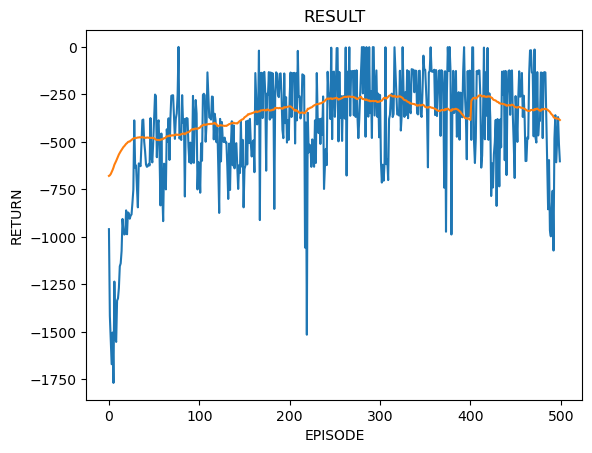

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
# 绘制最终的 return 并且保存图片
now = datetime.now().strftime('%Y%m%d%H%M%S')
sav_dir = '/home/gqbao/rl/ddpg/' + now
if not os.path.exists(sav_dir):
    os.makedirs(sav_dir)

plot_return(return_list, 100, True, sav_dir)
# 保存 return_list
np.save(sav_dir + '/' + 'return_list.npy', np.array(return_list))

In [34]:
# 保存模型
ddpg.save_net(sav_dir, True)

# 保存实验超参数
hyper_params = {'actor_lr': actor_lr, 'critic_lr': critic_lr, 'batch_size': batch_size,
                'buffer_capacity': buffer_capacity, 'sigma': sigma, 'is_decay_noise': is_decay_noise,
                'decay_factor': decay_factor, 'tau': tau, 'gamma': gamma,
                'episodes_num': episodes_num}

np.save(sav_dir + '/' + 'hyper_params.npy', hyper_params)

with open(sav_dir + '/' + 'log.txt', 'w+') as f:
    f.write('actor_lr: {}\n'.format(actor_lr))
    f.write('critic_lr: {}\n'.format(critic_lr))
    f.write('batch_size: {}\n'.format(batch_size))
    f.write('batch_size: {}\n'.format(batch_size))
    f.write('buffer_capacity: {}\n'.format(buffer_capacity))
    f.write('sigma: {}\n'.format(sigma))
    f.write('tau: {}\n'.format(tau))
    f.write('gamma: {}\n'.format(gamma))
    f.write('episodes_num: {}\n'.format(episodes_num))
    f.write('is_decay_noise: {}\n'.format(is_decay_noise))
    f.write('decay_factor: {}\n'.format(decay_factor))